MNIST Single head model

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch 
from torch import nn
import torchvision as TV
#initialize the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

mnist_data = TV.datasets.MNIST("MNIST/", train=True, transform=None,\
                                        target_transform=None, download=True)
mnist_test = TV.datasets.MNIST("MNIST/", train=False, transform=None,\
                                        target_transform=None, download=True)
 
 
def add_spots(x,m=20,std=5,val=1):
    mask = torch.zeros(x.shape)
    N = int(m + std * np.abs(np.random.randn()))
    ids = np.random.randint(np.prod(x.shape),size=N)
    mask.view(-1)[ids] = val
    return torch.clamp(x + mask,0,1)
 
def prepare_images(xt,maxtrans=6,rot=5,noise=0):
    out = torch.zeros(xt.shape)
    for i in range(xt.shape[0]):
        img = xt[i].unsqueeze(dim=0)
        img = TV.transforms.functional.to_pil_image(img)
        rand_rot = int(np.random.randint(-1*rot,rot,1) if rot > 0 else 0)
        xtrans,ytrans = np.random.randint(-maxtrans,maxtrans,2)
        img = TV.transforms.functional.affine(img, rand_rot, (xtrans,ytrans),1,0)
        img = TV.transforms.functional.to_tensor(img).squeeze()
        if noise > 0:
            img = add_spots(img,m=noise)
        maxval = img.view(-1).max()
        if maxval > 0:
            img = img.float() / maxval
        else:
            img = img.float()
        out[i] = img
    return out



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [ ]:
class RelationalModule (torch.nn.Module):
  def __init__(self):
    super(RelationalModule, self).__init__()
    self.ch_in =1
    #four conv layers to process the raw pixels into higher level features
    self.conv1_ch=16
    self.conv2_ch=20
    self.conv3_ch=24
    self.conv4_ch=30
    self.H= 28
    self.W=28
    #the dim of the node after passing throught the relational model 
    self.node_size= 36
    self.lin_hid= 100
    self.out_dim= 10
    self.sp_coord_dim= 2
    #the number of pixels after passing the convs
    self.N= int(16**2)

    self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(4,4))
    self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(4,4))
    self.conv3 = nn.Conv2d(self.conv2_ch,self.conv3_ch,kernel_size=(4,4))
    self.conv4 = nn.Conv2d(self.conv3_ch,self.conv4_ch,kernel_size=(4,4))

    #the dim of each node vectore is the num of channels in the last conv + 2 spatial dims
    self.proj_shape= (self.conv4_ch+self.sp_coord_dim, self.node_size)
    #key and value and query
    self.k_proj = nn.Linear(*self.proj_shape)
    self.q_proj = nn.Linear(*self.proj_shape)
    self.v_proj = nn.Linear(*self.proj_shape)

    self.norm_shape= (self.N, self.node_size)
    #the normalization is to improve the learning stability
    self.k_norm= nn.LayerNorm(self.norm_shape, elementwise_affine=True)
    self.q_norm= nn.LayerNorm(self.norm_shape, elementwise_affine=True)
    self.v_norm= nn.LayerNorm(self.norm_shape, elementwise_affine=True)


    self.linear1= nn.Linear(self.node_size, self.node_size)
    self.norm1= nn.LayerNorm([self.N, self.node_size], elementwise_affine=False)
    self.linear2= nn.Linear(self.node_size, self.out_dim)


  def forward(self, x):
    N, Cin, H, W= x.shape
    x= self.conv1(x)
    #activation function
    x= torch.relu(x)
    x= self.conv2(x)
    #Returns a tensor with all the dimensions of input of size 1 removed.
    x= x.squeeze()
    x= torch.relu(x)
    x= self.conv3(x)
    x= torch.relu(x)
    x= self.conv4(x)
    x= torch.relu(x)

    _,_,cH,cW= x.shape
    #appends the x,y coords of each node to its feature vectore and normalize 
    #to within the interval [0,1]
    xcoords= torch.arange(cW).repeat(cH,1).float()/cW
    ycoords= torch.arange(cH).repeat(cW,1).transpose(1,0).float()/cH
    spatial_coords= torch.stack([xcoords,ycoords], dim=0)
    spatial_coords= spatial_coords.unsqueeze(dim=0)
    spatial_coords= spatial_coords.repeat(N,1,1,1)
    spatial_coords= spatial_coords.to(device)


    #from here
    x = torch.cat([x,spatial_coords],dim=1)
    x = x.permute(0,2,3,1)
    x = x.flatten(1,2)
    
    K = self.k_proj(x)
    K = self.k_norm(K) 
    
    Q = self.q_proj(x)
    Q = self.q_norm(Q) 
    
    V = self.v_proj(x)
    V = self.v_norm(V) 
    A = torch.einsum('bfe,bge->bfg',Q,K)
    A = A / np.sqrt(self.node_size)
    A = torch.nn.functional.softmax(A,dim=2) 
    with torch.no_grad():
        self.att_map = A.clone()
    E = torch.einsum('bfc,bcd->bfd',A,V)
    E = self.linear1(E)
    E = torch.relu(E)
    E = self.norm1(E)  
    E = E.max(dim=1)[0]
    y = self.linear2(E)  
    y = torch.nn.functional.log_softmax(y,dim=1)
    return y


In [ ]:
###GPU
acc= []
los=[]
#define agent and transfere it to the GPU
agent = RelationalModule()
agent = agent.to(device)

epochs = 1000
batch_size=300
lr = 1e-3
opt = torch.optim.Adam(params=agent.parameters(),lr=lr)
lossfn = nn.NLLLoss()
for i in range(epochs):
    opt.zero_grad()
    batch_ids = np.random.randint(0,60000,size=batch_size)
    xt = mnist_data.train_data[batch_ids].detach()
    xt = prepare_images(xt,rot=30).unsqueeze(dim=1)
    #plt.imshow(xt.max(dim=0)[0].view(16,16))
    xt= xt.to(device)
    yt = mnist_data.train_labels[batch_ids].detach()
    yt= yt.to(device)
    pred = agent(xt)
    pred_labels = torch.argmax(pred,dim=1)
    #check the accuracy
    acc_ = 100.0 * (pred_labels == yt).sum() / batch_size
    acc.append(acc_)
    correct = torch.zeros(batch_size,10)
    rows = torch.arange(batch_size).long()
    correct[[rows,yt.detach().long()]] = 1.
    loss = lossfn(pred,yt)
    loss.backward()
    los.append(loss)
    opt.step()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([256, 256])


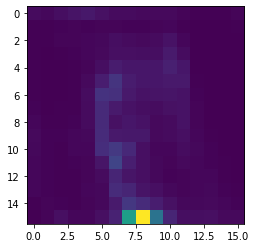

In [ ]:
plt.imshow(agent.att_map[0].cpu().max(dim=0)[0].view(16,16))
print(agent.att_map[0].cpu().size())

In [ ]:
x=[i for i in range(len(acc))]
accur= []
losses=[]
for i in range(len(acc)):
  accur.append(acc[i].item())
  losses.append(los[i].item())


In [ ]:
torch.Tensor.ndim = property(lambda self: len(self.shape))

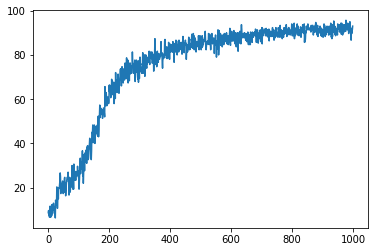

In [ ]:
#accuracy
plt.plot(x, accur)  # Works now
plt.show()

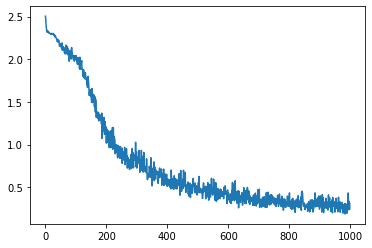

In [ ]:
#loss
plt.plot(x, losses)  # Works now
plt.show()

In [ ]:
def test_acc(model,batch_size=500):
    acc = 0.
    batch_ids = np.random.randint(0,10000,size=batch_size)
    xt = mnist_test.test_data[batch_ids].detach()
    xt = prepare_images(xt,maxtrans=6,rot=30,noise=10).unsqueeze(dim=1)
    xt= xt.to(device)
    yt = mnist_test.test_labels[batch_ids].detach()
    yt= yt.to(device)
    preds = model(xt)
    pred_ind = torch.argmax(preds.detach(),dim=1)
    acc = (pred_ind == yt).sum().float() / batch_size
    plt.imshow(agent.att_map[0].cpu().max(dim=0)[0].view(16,16))
    #plt.
    return acc, xt, yt


In [ ]:
acc2, xt2, yt2 = test_acc(agent)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
acc2

tensor(0.7660, device='cuda:0')

In [ ]:
accT = 0.
batch_ids = np.random.randint(0,10000,size=batch_size)
xt = mnist_test.test_data[batch_ids].detach()
xt = prepare_images(xt,maxtrans=6,rot=30,noise=10).unsqueeze(dim=1)

#print(xt.cpu().size())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([300, 1, 28, 28])


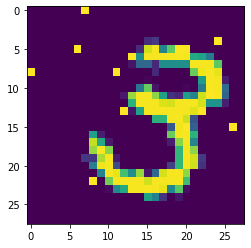

In [ ]:
print(xt.size())
plt.imshow(xt[0].view(28,28))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


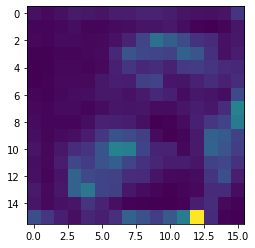

In [ ]:
xt= xt.to(device)
yt = mnist_test.test_labels[batch_ids].detach()
yt= yt.to(device)
preds = agent(xt)
pred_ind = torch.argmax(preds.detach(),dim=1)
accT = (pred_ind == yt).sum().float() / batch_size
plt.imshow(agent.att_map[0].cpu().max(dim=0)[0].view(16,16))
#plt.imshow(xt)

In [ ]:
accT

tensor(0.8967, device='cuda:0')

##Multi-head attention and relational DQN

first lets try it with the gym-minigrid

In [ ]:
pip install gym-minigrid

     |████████████████████████████████| 48 kB 2.2 MB/s 


In [ ]:
pip install einops

In [ ]:
from einops import rearrange

In [ ]:
class MultiHeadRelationalModule(torch.nn.Module):
    def __init__(self):
        super(MultiHeadRelationalModule, self).__init__()
        self.conv1_ch = 16 
        self.conv2_ch = 20
        self.conv3_ch = 24
        self.conv4_ch = 30
        self.H = 28
        self.W = 28
        self.node_size = 64
        self.lin_hid = 100
        self.out_dim = 5
        self.ch_in = 3
        self.sp_coord_dim = 2
        self.N = int(7**2)
        self.n_heads = 3
        
        self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(1,1),padding=0) #A
        self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(1,1),padding=0)
        self.proj_shape = (self.conv2_ch+self.sp_coord_dim,self.n_heads * self.node_size)
        self.k_proj = nn.Linear(*self.proj_shape)
        self.q_proj = nn.Linear(*self.proj_shape)
        self.v_proj = nn.Linear(*self.proj_shape)

        self.k_lin = nn.Linear(self.node_size,self.N) #B
        self.q_lin = nn.Linear(self.node_size,self.N)
        self.a_lin = nn.Linear(self.N,self.N)
        
        self.node_shape = (self.n_heads, self.N,self.node_size)
        self.k_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        self.q_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        self.v_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        
        self.linear1 = nn.Linear(self.n_heads * self.node_size, self.node_size)
        self.norm1 = nn.LayerNorm([self.N,self.node_size], elementwise_affine=False)
        self.linear2 = nn.Linear(self.node_size, self.out_dim)
    
    def forward(self,x):
        N, Cin, H, W = x.shape
        x.to(device)
        x = self.conv1(x) 
        x = torch.relu(x).to(device)
        x = self.conv2(x) 
        x = torch.relu(x).to(device)
        with torch.no_grad(): 
            self.conv_map = x.clone() #C
        _,_,cH,cW = x.shape
        xcoords = torch.arange(cW).repeat(cH,1).float() / cW
        xcoords= xcoords.to(device)
        ycoords = torch.arange(cH).repeat(cW,1).transpose(1,0).float() / cH
        ycoords= ycoords.to(device)
        spatial_coords = torch.stack([xcoords,ycoords],dim=0)
        spatial_coords = spatial_coords.unsqueeze(dim=0)
        spatial_coords = spatial_coords.repeat(N,1,1,1)
        spatial_coords = spatial_coords.to(device)
        x = torch.cat([x,spatial_coords],dim=1)
        x = x.permute(0,2,3,1)
        x = x.flatten(1,2)
        x= x.to(device)
        
        K = rearrange(self.k_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        K = self.k_norm(K) 
        
        Q = rearrange(self.q_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        Q = self.q_norm(Q) 
        
        V = rearrange(self.v_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        V = self.v_norm(V) 
        A = torch.nn.functional.elu(self.q_lin(Q) + self.k_lin(K)) #D
        A = self.a_lin(A)
        A = torch.nn.functional.softmax(A,dim=3) 
        with torch.no_grad():
            self.att_map = A.clone() #E
        E = torch.einsum('bhfc,bhcd->bhfd',A,V) #F
        E = rearrange(E, 'b head n d -> b n (head d)')
        E = self.linear1(E)
        E = torch.relu(E)
        E = self.norm1(E)
        E = E.max(dim=1)[0]
        y = self.linear2(E)
        y = torch.nn.functional.elu(y)
        return y

In [ ]:
import gym
from gym_minigrid.minigrid import *
from gym_minigrid.wrappers import FullyObsWrapper, ImgObsWrapper
from skimage.transform import resize
 
def prepare_state(x):
    ns = torch.from_numpy(x).float().permute(2,0,1).unsqueeze(dim=0)#
    maxv = ns.flatten().max()
    ns = ns / maxv
    return ns
 
def get_minibatch(replay,size):
    batch_ids = np.random.randint(0,len(replay),size)
    batch = [replay[x] for x in batch_ids] #list of tuples
    state_batch = torch.cat([s for (s,a,r,s2,d) in batch],)
    state_batch= state_batch.to(device)
    action_batch = torch.Tensor([a for (s,a,r,s2,d) in batch]).long()
    acrion_batch= action_batch.to(device)
    reward_batch = torch.Tensor([r for (s,a,r,s2,d) in batch])
    reward_batch= reward_batch.to(device)
    state2_batch = torch.cat([s2 for (s,a,r,s2,d) in batch],dim=0)
    state2_batch= state2_batch.to(device)
    done_batch = torch.Tensor([d for (s,a,r,s2,d) in batch])
    done_batch= done_batch.to(device)
    return state_batch,action_batch,reward_batch,state2_batch, done_batch
 
def get_qtarget_ddqn(qvals,r,df,done):
    targets = r + (1-done) * df * qvals
    return targets


In [ ]:
#the loss function
def lossfn(pred,targets,actions):
    loss = torch.mean(torch.pow(targets.detach()-pred.gather(dim=1,index=actions.unsqueeze(dim=1)).squeeze(),2),dim=0).to(device)
    return loss

#update the experince replay
'''
The update_replay function adds new memories to the experience replay if it is
not yet full; if it is full, it will replace random memories with new ones. If 
the memory resulted in a positive reward, we add 50 copies of that memory, 
since positive reward memories are rare and we want to enrich the 
experience replay with these more important memories.
'''
def update_replay(replay,exp,replay_size):
  r = exp[2]
  N = 1
  if r > 0:
      N = 50
  for i in range(N):
      replay.append(exp)
  return replay
 
action_map = {
    0:0, 
    1:1,
    2:2,
    3:3,
    4:5,
}


In [ ]:
from collections import deque
env = ImgObsWrapper(gym.make('MiniGrid-DoorKey-5x5-v0'))
#env= env.to(device)
state = prepare_state(env.reset()) 
GWagent = MultiHeadRelationalModule()
GWagent= GWagent.to(device)
Tnet = MultiHeadRelationalModule()
Tnet= Tnet.to(device)
maxsteps = 400
env.max_steps = maxsteps
env.env.max_steps = maxsteps
#loss
los=[]
 
epochs = 50000
replay_size = 9000
batch_size = 50
lr = 0.0005
gamma = 0.99
replay = deque(maxlen=replay_size)
opt = torch.optim.Adam(params=GWagent.parameters(),lr=lr)
eps = 0.5
update_freq = 100
for i in range(epochs):
    pred = GWagent(state.to(device))
    action = int(torch.argmax(pred).detach().cpu().numpy())
    if np.random.rand() < eps:
        action = int(torch.randint(0,5,size=(1,)).squeeze())
    action_d = action_map[action]
    state2, reward, done, info = env.step(action_d)
    reward = -0.01 if reward == 0 else reward
    state2 = prepare_state(state2)
    exp = (state,action,reward,state2,done)
    
    replay = update_replay(replay,exp,replay_size)
    if done:
        state = prepare_state(env.reset())
    else:
        state = state2
    if len(replay) > batch_size:
        
        opt.zero_grad()
        
        state_batch,action_batch,reward_batch,state2_batch,done_batch = get_minibatch(replay,batch_size)
        
        #q_pred = GWagent(state_batch).cpu()
        q_pred = GWagent(state_batch)
        astar = torch.argmax(q_pred,dim=1).to(device)
        qs =Tnet(state2_batch).gather(dim=1,index=astar.unsqueeze(dim=1)).squeeze()
        
        targets = get_qtarget_ddqn(qs.detach(),reward_batch.detach(),gamma,done_batch)
        
        loss = lossfn(q_pred.to(device),targets.detach().to(device),action_batch.to(device))
        loss.backward()
        los.append(loss)
        torch.nn.utils.clip_grad_norm_(GWagent.parameters(), max_norm=1.0)
        opt.step()
    if i % update_freq == 0:
        Tnet.load_state_dict(GWagent.state_dict())



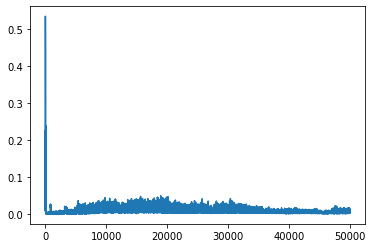

In [ ]:
x=[i for i in range(len(los))]
losses=[]
for i in range(len(los)):
  losses.append(los[i].item())

plt.plot(x, losses)
plt.show()

The pong environment

Env Not working 

In [1]:
pip install gym[atari,accept-rom-license]==0.21.0


#

In [1]:
pip install -U gym

     |████████████████████████████████| 626 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701375 sha256=402d0f18aa99cb1c3bd1dcf9a4423cd735ee09ea271753d99836fa04a52174b8
  Stored in directory: /root/.cache/pip/wheels/e3/33/04/6723848e46f0f1ebe794bb329b7c761c3329a0d7ffade99da7
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


#

In [2]:
pip install -U gym[atari,accept-rom-license]

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=921b8bfbda316306626f9a97005b3fb754571f5247a16df73ffb3d58cd000419
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


#

In [3]:
pip install atari-py

؟#

In [ ]:
!AutoROM --accept-license

In [10]:
pip install gym[atari]

second attempt/

In [1]:
pip install ale-py

In [2]:
from ale_py import ALEInterface

ale = ALEInterface()

In [6]:
!ale-import-roms roms/

Path roms doesn't exist.


In [9]:
import numpy as np
import gym
import random

In [18]:
!sudo apt-get install x11-apps

!export DISPLAY=:0

!xeyes


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  xbitmaps
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  x11-apps xbitmaps
0 upgraded, 2 newly installed, 0 to remove and 67 not upgraded.
Need to get 681 kB of archives.
After this operation, 2,550 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-apps amd64 7.7+6ubuntu1 [653 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 xbitmaps all 1.1.1-2 [28.1 kB]
Fetched 681 kB in 1s (625 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm

In [19]:
# code for the two only actions in Pong
UP_ACTION = 2
DOWN_ACTION = 3
#init an env
env = gym.make('ALE/Pong-v5', render_mode='human')

# beginning of an episode
observation = env.reset()

RuntimeError: ignored

In [15]:
# main loop
for i in range(300):
    # render a frame
    env.render(mode='human')

    # choose random action
    action = random.randint(UP_ACTION, DOWN_ACTION) 

    # run one step
    observation, reward, done, info = env.step(action)

    # if the episode is over, reset the environment
    if done:
        env.reset()

Error: ignored